https://colab.research.google.com/notebooks/mlcc/first_steps_with_tensor_flow.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=firststeps-colab&hl=en#scrollTo=EL8-9d4ZJNR7

Very broadly speaking, here's the pseudocode for a linear classification program implemented in tf.estimator:

In [1]:
import tensorflow as tf

# Set up a linear classifier.
classifier = tf.estimator.LinearClassifier(feature_columns)

# Train the model on some example data.
classifier.train(input_fn=train_input_fn, steps=2000)

# Use it to predict.
predictions = classifier.predict(input_fn=predict_input_fn)

C:\Users\bradburj\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


NameError: name 'feature_columns' is not defined

Load the necessary libraries

In [1]:
from __future__ import print_function

import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

C:\Users\bradburj\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Next, we'll load our data set.

In [3]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

Randomise the data, to be sure there we do not get any pathological ordering effetcs that might harm the performance of Stochastic Gradient Descent.
Additionally, we'll scale `median_house_value` to be in units of thousands, so it can be learned a little more easily with learning rates that are usually used.

In [4]:
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
5844,-118.2,34.0,52.0,774.0,209.0,813.0,203.0,2.3,135.2
2374,-117.5,33.8,22.0,2397.0,400.0,1347.0,403.0,4.5,189.8
10992,-120.9,37.7,10.0,7566.0,1348.0,3227.0,1199.0,4.7,148.1
14174,-122.1,37.4,19.0,1465.0,342.0,646.0,345.0,4.7,289.3
13104,-121.9,37.4,13.0,3334.0,565.0,2240.0,561.0,7.1,273.9
...,...,...,...,...,...,...,...,...,...
3407,-117.9,34.1,35.0,1470.0,241.0,885.0,246.0,4.9,168.8
3346,-117.9,34.1,23.0,2308.0,322.0,1001.0,317.0,7.5,355.5
16249,-122.5,38.3,17.0,3308.0,720.0,1587.0,632.0,3.3,176.0
14583,-122.2,37.7,43.0,1534.0,300.0,826.0,295.0,4.0,109.4


## Examine the Data
It's a good idea to get to know the data a little bit before working with it

In [5]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


## Build the first model
In this exercise, we'll try to predict `median_house_value`, which will be our label. We'll use `total_rooms` as our input feature.

**NOTE:** The data is at the city block level, so this feature represents the total number of rooms in that block

To train the model, we'll usethe  LinearRegressor interface provided by the TensorFlow Estimator API. This API takes care of a lot of the low-level model plumbing, and exposes convinient methods for performing model traiing, evaluation and inference.

### Step 1: Define Features and Configure Feature Columns
In order to import our training data into TensorFlow, we need to specify what type of data each feature contains. There are two main types of data that will be used in this course:
  - **Categorical Data: ** Textual data
  - **Numerical Data: ** Integer or float

In TensorFlow, we indicate a feature's data type using a construct called a **feature column**. Feature columns store only a description of the feature data; they do not contain the feature data itself.

To start, we're going to use just one numeric input feature, `total_rooms`. The following code pulls the `total_rooms` data from our `california_housing_dataframe` and defines the feature column using `numeric_column`, which specifies its data is numeric:

In [6]:
# Define the input feature: total_rooms.
my_feature = california_housing_dataframe[["total_rooms"]]

# Configure a numeric feature column for total_rooms.
feature_columns = [tf.feature_column.numeric_column("total_rooms")]

**NOTE:** The shape of the `total_rooms` data is a one-dimensional array (a list of the total number of rooms in each block). This is the default shape for `numeric_column`, so we don't have to pass it an argument.

### Step 2: Define the Target
Next, we'll define our target, which is `median_house_value`. Again, we can pull it from our `california_housing_dataframe`:

In [7]:
# Define the label.
targets = california_housing_dataframe["median_house_value"]

### Step 3: Configure the LinearRegressor
Next, we'll configure a linear regression model using LinearRegressor. We'll train this model using the `GradientDescentOptimizer`, which implements Min-Batch Stochastic Gradient Descent (SGD). The `learning_rate` argument controls the size of the gradient step.

**NOTE: ** To be safe, we also apply gradient clipping to our optimiser via `clip_gradients_by_norm`. Gradient clipping ensures the magnitude of the gradients do not become too large during training, which can cause gradient descent to fails.

In [8]:
# Use gradient descent as the optimiser for training the model.
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)

### Step 4: Define the Input Function
To import our California housing data into our `LinearRegressor`, we need to define an input function, which instructs TensorFlow how to preprocess the data, as well as how to batch, shuffle, and repeat it during model training.

First, we'll convert our *pandas* feature data into a dict of NumPy arrays. We can then use the TensorFlow Dataset API to construct a dataset object from our data, and then break our data into batches of `batch_size`, to be repeated for the specified number of epochs (num_epochs)

**NOTE: **when the default value of `num_epochs=None` is passed to `repeat()`, the input data will be repeated indefinitley.

Next, if `shuffle` is set to `True`, we'll shuffle the data so that it's passed to the model randomly during training. The `buffer_size` argument specifies the size of the dataset from which `shuffle` will randomly sample.

Finally, our input function constructs an iterator fot the dataset and returns the next batch of data to the LinearRegressor.

In [9]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
    
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitley
    Returns:
      Tuple of (features, labels) for the next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}
    
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features, targets)) # warning 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
        
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()    
    return features, labels

**Note:** We'll continue to use this same input function in later exercises.

### Step 5: Train the model
We can now call `train()` on our `linear_regressor` to train the model. We'll wrap `my_input_fn` in a `lambda` so we can pass in `my_feature` and `target` as arguments, and to start, we'll train for 100 steps.

In [10]:
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

### Step 6: Evaluate the model
Let's make predictions on that training data, to see how well our model fit it during training.

**NOTE:** Training error measures how well your model fits the training data, but it ***does not*** measure how well your model ***generalizes to new data.*** In later exercises, you'll explore how to split your data to evaluate your model's ability to generalize.

In [12]:
# Create an input function for predictions.
# Note: Since we're making just one prediction for each example, we don't
# need to repeat or shuffle the data here.
prediction_input_fn = lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 56367.025
Root Mean Squared Error (on training data): 237.417


Is this a good model? How would you judge how large this error is?

Mean Squared Error (MSE) can be hard to interpret, so we often look at Root Mean Squared Error (RMSE) instead. A nice property of RSME is that it can be interpreted on the same scale as the original targets

Let's compare the RMSE to the difference of the min and max of our targets

In [15]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.417


The error spans nearly half the range of the target values. Can we do better?

This is the question that nags at every model developer. Let's develop some basic stratergies to reduce model error.

The first thing we can do is take a look at how well our predictions match our targets, in terms of overall summary statistics.

In [16]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


Okay, maybe this information is helpful. How does the mean value compare to the model's RMSE? How about the various quantiles?

We can also visualize the data and the line we've learned. Recall that linear regression on a single feature can be drawn as a line mapping input *x* to output *y* .

First, we'll get a uniform random sample of the data so we can make a readable scatter plot.

In [17]:
sample = california_housing_dataframe.sample(n=300)

Next, we'll plot the line we've learned, drawing from the model's bias term and feature weight, together with the scatter plot. The line will show up red.

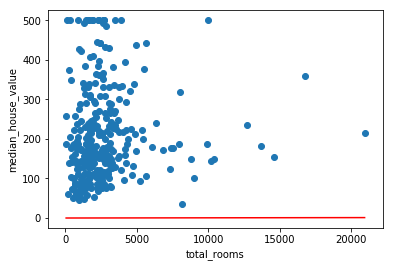

In [18]:
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrive the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Display graph
plt.show()

The initial line looks way off. See if you can look back at the summary stats and see the same information encoded there.

Together, these initial sanity checks suggest we may be able to find a much better line.

## Tweak the Model Hyperparameters
For this exercise, we've put all the above code in a single function for convenience. You can call the function with different paramters to see the effect.

In this function, we'll proceed in 10 evenly divided periods so that we can observe the model improvement at each period.

For each period, we'll compute and graph training loss. This may help you judge when a model is converegd, or if it needs more iterations.

We'll also plot the feature weight and bias term values learned by our model over time. This is another way to see how things converge.

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
    """Trains a linear regression model of one feature
    
    Args:
        learning_rate: A `float`, the learning rrate
        steps: A non-zero `int`, the total number of training steps. A training step 
            consists of a forward and backward pass using a single batch
        batch_size: A non-zero `int`, the batch size.
        input_feature: A `string` specifying a column from `california_housing_dataframe`
            to use as an input feature.
    """
    
    periods = 10
    steps_per_period = steps / periods
    
    my_feature = input_feature
    my_feature_data = california_housing_dataframe[[my_feature]]
    my_label = "median_house_value"
    targets = california_housing_dataframe[my_label]
    
    # Create feature coumns.
    feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
    # Create input functions.
    training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
    prediction_input_fn = lambda:my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
    
    # Create a linear regressor object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=my_optimizer
    )
    
    # Set up the plot state of our model's line each period.
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learned Line by Period")
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    sample = california_housing_dataframe.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]
    
    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    root_mean_squared_errors = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        
        # Compute loss.
        root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(predictions, targets))
        # Occasionally print the current loss.
        print("    period %02d : %0.2f" % (period, root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        root_mean_squared_errors.append(root_mean_squared_error)
        # Finally, track the weights and biases over time.
        # Apply some math to ensure that the data and line are plotted neatly.
        y_extents = np.array([0, sample[my_label].max()])
        
        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
        
        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents,
                                         sample[my_feature].max()),
                              sample[my_feature].min())
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period])
    print("Model training finished.")
    
    # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)
    
    # Output a table with calibration data.
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(targets)
    display.display(calibration_data.describe())
    
    print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

Training model...
RMSE (on training data):
    period 00 : 225.63
    period 01 : 214.42
    period 02 : 204.04
    period 03 : 194.62
    period 04 : 186.29
    period 05 : 180.53
    period 06 : 174.58
    period 07 : 171.74
    period 08 : 168.84
    period 09 : 167.37
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,116.3,207.3
std,95.9,116.0
min,0.1,15.0
25%,64.3,119.4
50%,93.6,180.4
75%,138.7,265.0
max,1669.2,500.0


Final RMSE (on training data): 167.37


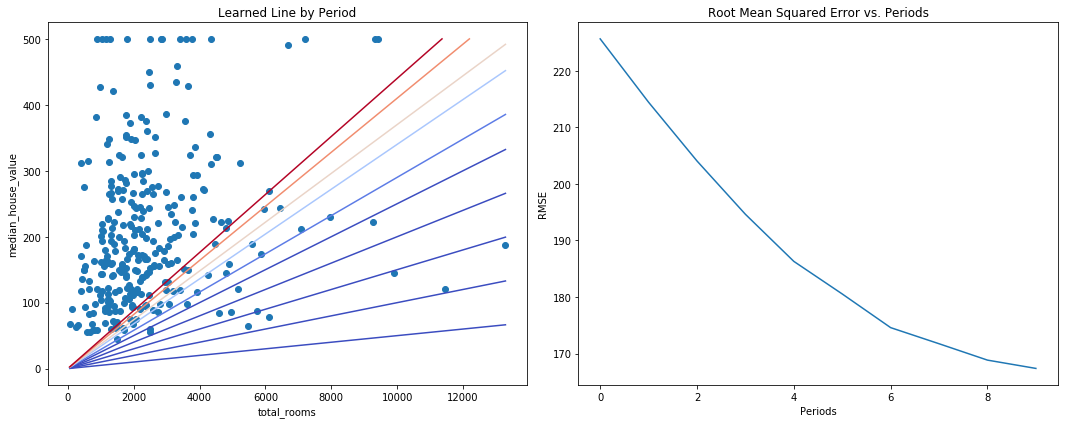

In [30]:
train_model(
    learning_rate=0.0001,
    steps=100,
    batch_size=1
)

Training model...
RMSE (on training data):
    period 00 : 225.63
    period 01 : 214.85
    period 02 : 205.24
    period 03 : 196.05
    period 04 : 188.18
    period 05 : 181.62
    period 06 : 177.50
    period 07 : 172.62
    period 08 : 170.45
    period 09 : 168.08
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,112.1,207.3
std,92.4,116.0
min,0.1,15.0
25%,62.0,119.4
50%,90.2,180.4
75%,133.6,265.0
max,1608.5,500.0


Final RMSE (on training data): 168.08


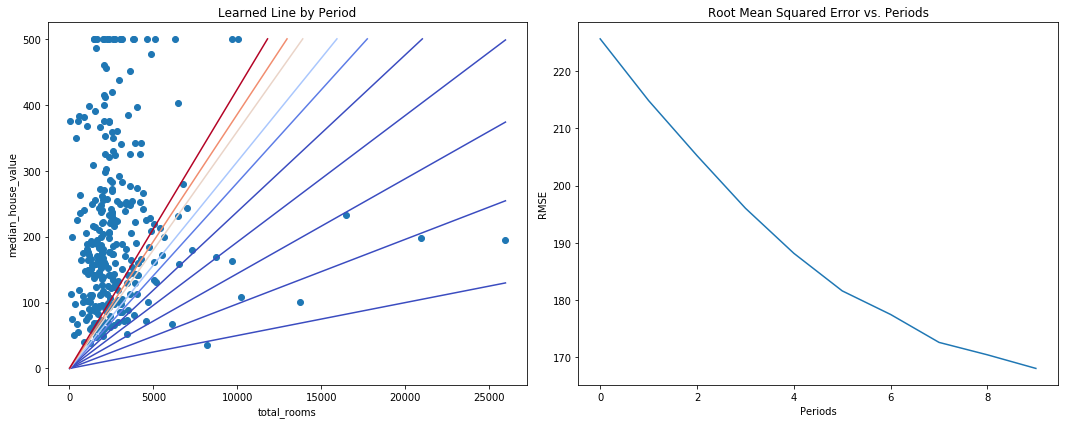

In [33]:
train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=5
)

Training model...
RMSE (on training data):
    period 00 : 232.70
    period 01 : 227.96
    period 02 : 223.32
    period 03 : 218.81
    period 04 : 214.42
    period 05 : 210.16
    period 06 : 206.04
    period 07 : 202.07
    period 08 : 198.26
    period 09 : 194.62
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,52.9,207.3
std,43.6,116.0
min,0.0,15.0
25%,29.2,119.4
50%,42.5,180.4
75%,63.0,265.0
max,758.7,500.0


Final RMSE (on training data): 194.62


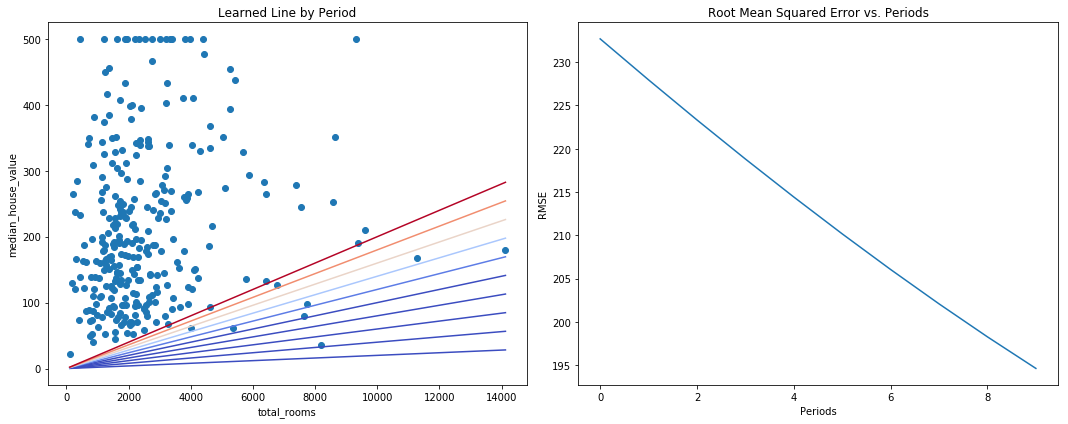

In [34]:
train_model(
    learning_rate=0.00002,
    steps=200,
    batch_size=10
)

### Is There a Standard Heuristic for Model Tunung?
This is a commonly asked question. The short answer is that the effect of different hyperparameters are data dependent. So there are no hard-and-fast rules; you'll need to test on your own data.

That said, here are a few rules of thumb that can help guide:
  - Training error should steadily decrease, steeply at first, and should eventaully plateau as training converges.
  - If the training has not converged, try running it for longer.
  - If the training error decreases too slowly, increaseing the learning rate may help it decrease faster.
    - But sometimes the exact opposite may happen if the learning rate is too high.
  - If the training error varies wildy, try decreasing the learning rate.
    - Lower learning rate plus longer number of steps or larger batch size is often a good combination.
  - Very small batch sizes can also cause instability. First try larger values like 100 or 1000, and decrease until you see degredation.
  
Again, never go strictly by these rules of thumb, becasue the effects are data dependent. Always experiment and verify.

## Task 2: Try a Different Feature
See if you can do any better by replacing the `total_rooms` feature with the `population` feature.

Training model...
RMSE (on training data):
    period 00 : 231.48
    period 01 : 225.63
    period 02 : 220.23
    period 03 : 214.84
    period 04 : 209.71
    period 05 : 204.86
    period 06 : 200.49
    period 07 : 196.26
    period 08 : 192.37
    period 09 : 188.85
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,70.9,207.3
std,56.9,116.0
min,0.1,15.0
25%,39.2,119.4
50%,57.9,180.4
75%,85.4,265.0
max,1769.8,500.0


Final RMSE (on training data): 188.85


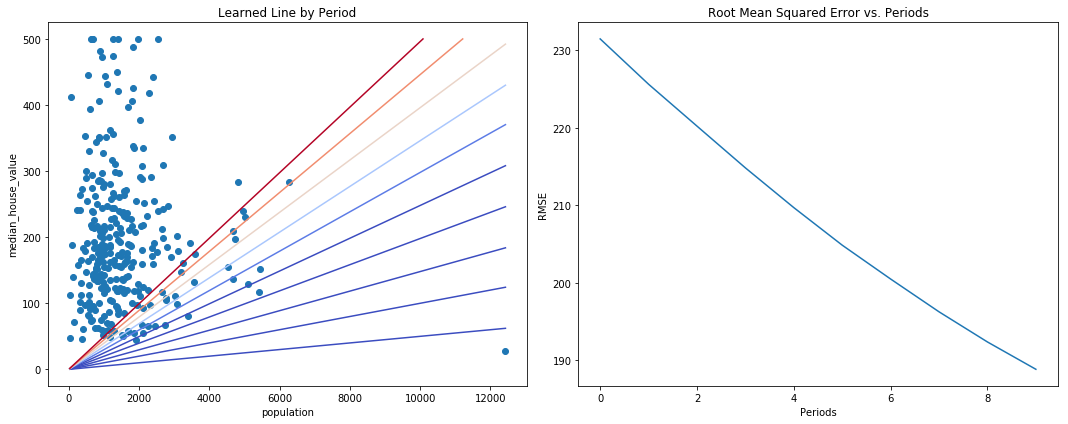

In [42]:
train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=50,
    input_feature="population"
)